# Toy Models of Superposition

Let's run through an example using Anthropic's toy models of superposition. 

This example is mostly to test that our SGLD estimator is working as expected and to figure out how to integrate this in an SGD setting.

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Iterable, Optional
import os

from scipy.spatial import ConvexHull
import wandb
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
import sys
sys.path.append("/home/paperspace/devinterp/")
from devinterp.optim.sgld import SGLD
from devinterp.zoo.tms import ToyAutoencoder, SyntheticUniformValued, SyntheticBinaryValued

DEVICE = os.environ.get("DEVICE", "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

In [2]:
def train(
    model: torch.nn.Module,
    dataset: Dataset,
    batch_size: Optional[int]=1,
    num_epochs: int=100,
    lr: float=0.001,
    log_ivl: Iterable[int]=[],
    device=DEVICE,
    momentum=0.9,
    weight_decay=0.0
):  
    batch_size = batch_size or len(dataset)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    logs = pd.DataFrame([{ "loss": None, "acc": None, "step": step} for step in log_ivl])
    weights = []

    model.to(device)

    def log(step):
        loss = 0.
        acc = 0.
        length = 0

        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            loss += criterion(outputs, batch).item()
            acc += (outputs.round() == batch).float().sum().item()
            length += len(batch)

        loss /= length
        acc /= length

        logs.loc[logs["step"] == step, ["loss", "acc"]] = [loss, acc]
        encoding_weights = model.embedding.weight.detach().cpu().clone().numpy()
        weights.append(encoding_weights)
            
    step = 0
    log(step)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        for batch in dataloader:
            batch = batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            step += 1

            if step in log_ivl:
                log(step)


    return logs, weights


In [3]:
import numpy as np

def plot_polygon(W: torch.Tensor, b=None, ax=None, ax_bias=None, ax_wnorm=None, hull_alpha=0.3, dW=None, dW_scale=0.3, orderb=True):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2: 
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

    if W.shape[0] == 2: # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0, 0, 
                W_sorted[0, i], W_sorted[1, i], 
                angles="xy", scale_units="xy", scale=1, 
                width=0.003
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col], W[1, col], 
                    dW[0, col], dW[1, col], 
                    angles="xy", 
                    scale_units="xy", 
                    scale=1, 
                    color="r",
                    width=0.005
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")
    
    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")
        
        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], 'b-')

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")
    
    if b is not None and ax_bias is not None:
        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ['r' if val < 0 else 'b' for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(yticks - 0.4, np.abs(b_plot), height=0.4, color=bar_colors, align="edge",)
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis='y', labelsize="x-small")
        ax_bias.tick_params(axis='x', labelsize="x-small")
    
    if ax_wnorm is not None:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax

def plot_polygons(Ws):
    fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W in zip(axes, Ws):
        plot_polygon(W, ax=ax)

Training: 100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


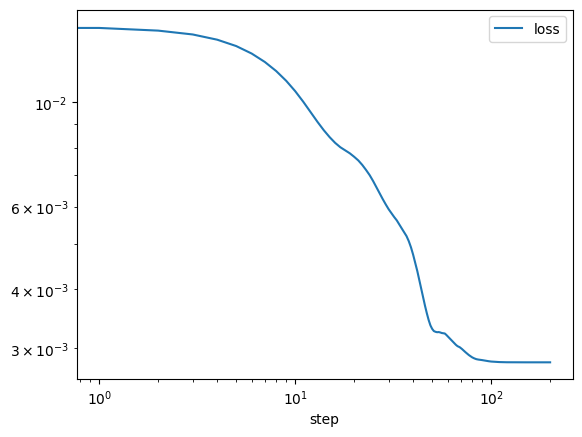

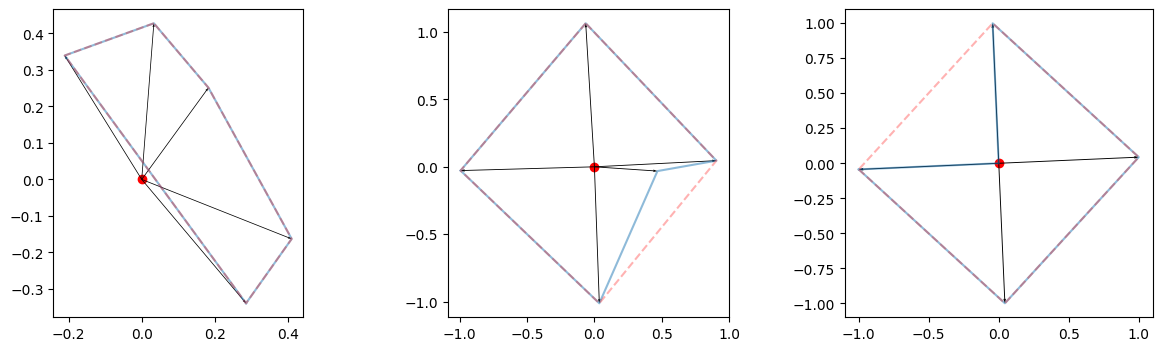

In [4]:
import numpy as np

NUM_FEATURES = 5
torch.manual_seed(0)
dataset = SyntheticBinaryValued(100, NUM_FEATURES, 1)
model = ToyAutoencoder(NUM_FEATURES, 2)
log_ivl = np.array([*range(100), *range(100, 250, 10), *range(250, 1000, 50)]) 


logs, weights = train(model, dataset, log_ivl=log_ivl, batch_size=10, lr=0.1, num_epochs=20)
logs.plot(y="loss", x="step", logx=True, logy=True)
weights_to_plot = [weights[0], weights[len(weights) // 2], weights[-1]]
plot_polygons(weights_to_plot)